# Red Inicial


## Imports


In [1]:
from __future__ import annotations

from time import perf_counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from custom_env.actions import Acciones
from custom_env.router_env import RouterEnv
from gymnasium import make
from gymnasium.utils.env_checker import check_env
from pandas import DataFrame, Series
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.logger import Logger, configure
from stable_baselines3.common.monitor import Monitor

Cargado a las 2025-03-26 22:46:43.671914


In [2]:
name = "./models/Example"
logs_path = "./logs/train/"
models_path = "./models/"
env_id = "RouterEnv-v0"

progress_bar = True
if progress_bar == True:
    import rich
    import tqdm

## Clases y Funciones


In [ ]:
tiempo_global: float = 0.0
iteraciones = 0
# Decaorador auxiliar para poder medir el tiempo de las funciones


def medir_tiempo(activado=False):
    def fun(funcion):
        def wrapper(*args, **kwargs):
            if not activado:
                return funcion(*args, **kwargs)
            fun_tiempo = perf_counter
            inicio: float = fun_tiempo()
            resultado = funcion(*args, **kwargs)
            tiempo_total: float = fun_tiempo() - inicio
            global tiempo_global, iteraciones
            medida = 1e6
            t: float = tiempo_total*medida
            tiempo_global += t
            iteraciones += 1
            print(f"Tiempo de ejecución de {
                funcion.__name__}: {t:.2f} micro-segundos")
            return resultado
        return wrapper
    return fun


def calcular_stats_acciones(acciones):
    if isinstance(acciones[-1], int):
        acciones = [Acciones.int_to_action(a) for a in acciones]
    print(f"{Acciones.DENEGAR.name}: {acciones.count(Acciones.DENEGAR)/len(acciones):.2%}")
    print(f"{Acciones.PERMITIR.name}: {acciones.count(Acciones.PERMITIR)/len(acciones):.2%}")

## Entrenamiento


In [4]:
seed = None
env: RouterEnv = make(env_id, seed=seed)

check_env(env)

print("Seed: ", env._np_random_seed)

new_logger: Logger = configure(logs_path, ["stdout", "csv"])
env = Monitor(env, logs_path)


model: PPO = PPO("MultiInputPolicy", env,
                 verbose=True)


model.set_logger(new_logger)
try:
    model.learn(total_timesteps=int(1e5//0.5),
                progress_bar=progress_bar)
except KeyboardInterrupt:
    print("Entrenamiento interrumpido")


g: str = input("¿Desea guardarlo? (s/n) ")
if g.lower() == "s":
    model.save(name)
    print("Modelo guardado")

Seed:  62613735021924157778568281527933630441
Logging to ./logs/train/
Using cpu device
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -662     |
| time/              |          |
|    fps             | 568      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -384         |
| time/                   |              |
|    fps                  | 475          |
|    iterations           | 2            |
|    time_elapsed         | 8            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0010224053 |
|    clip_fraction        | 0            |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.693       |
|    explained_variance   | 0.000509     |
|    learning_rate        | 0.0003       |
|    loss                 | 1.53e+03     |
|    n_updates            | 10           |
|    policy_gradient_loss | 0.000285     |
|    value_loss           | 4.15e+03     |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -635        |
| time/                   |             |
|    fps                  | 453         |
|    iterations           | 3           |
|    time_elapsed         | 13          |
|    total_timesteps      | 6144        |
| train/                  |             |
|    approx_kl            | 0.019766599 |
|    clip_fraction        | 0.178       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.676      |
|    explained_variance   | 0.0133      |
|    learning_rate        | 0.0003      |
|    loss                 | 31.3        |
|    n_updates            | 20          |
|    policy_gradient_loss | -0.0184     |
|    value_loss           | 88          |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -461          |
| time/                   |               |
|    fps                  | 461           |
|    iterations           | 4             |
|    time_elapsed         | 17            |
|    total_timesteps      | 8192          |
| train/                  |               |
|    approx_kl            | 0.00015634055 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.674        |
|    explained_variance   | 0.0167        |
|    learning_rate        | 0.0003        |
|    loss                 | 5.54e+03      |
|    n_updates            | 30            |
|    policy_gradient_loss | -0.00047      |
|    value_loss           | 1.34e+04      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -550          |
| time/                   |               |
|    fps                  | 463           |
|    iterations           | 5             |
|    time_elapsed         | 22            |
|    total_timesteps      | 10240         |
| train/                  |               |
|    approx_kl            | 0.00014289503 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.673        |
|    explained_variance   | 0.0345        |
|    learning_rate        | 0.0003        |
|    loss                 | 573           |
|    n_updates            | 40            |
|    policy_gradient_loss | -7.28e-05     |
|    value_loss           | 2.56e+03      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -669          |
| time/                   |               |
|    fps                  | 463           |
|    iterations           | 6             |
|    time_elapsed         | 26            |
|    total_timesteps      | 12288         |
| train/                  |               |
|    approx_kl            | 4.0519473e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.673        |
|    explained_variance   | 0.087         |
|    learning_rate        | 0.0003        |
|    loss                 | 1.13e+03      |
|    n_updates            | 50            |
|    policy_gradient_loss | -9.16e-05     |
|    value_loss           | 6.26e+03      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -720          |
| time/                   |               |
|    fps                  | 465           |
|    iterations           | 7             |
|    time_elapsed         | 30            |
|    total_timesteps      | 14336         |
| train/                  |               |
|    approx_kl            | 0.00014784893 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.675        |
|    explained_variance   | 0.15          |
|    learning_rate        | 0.0003        |
|    loss                 | 4e+03         |
|    n_updates            | 60            |
|    policy_gradient_loss | -0.000225     |
|    value_loss           | 1.09e+04      |
-------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -642          |
| time/                   |               |
|    fps                  | 462           |
|    iterations           | 8             |
|    time_elapsed         | 35            |
|    total_timesteps      | 16384         |
| train/                  |               |
|    approx_kl            | 0.00033486923 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.678        |
|    explained_variance   | 0.153         |
|    learning_rate        | 0.0003        |
|    loss                 | 5.36e+03      |
|    n_updates            | 70            |
|    policy_gradient_loss | -0.000499     |
|    value_loss           | 1.21e+04      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -577        |
| time/                   |             |
|    fps                  | 456         |
|    iterations           | 9           |
|    time_elapsed         | 40          |
|    total_timesteps      | 18432       |
| train/                  |             |
|    approx_kl            | 0.007849989 |
|    clip_fraction        | 0.0427      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.667      |
|    explained_variance   | 0.488       |
|    learning_rate        | 0.0003      |
|    loss                 | 64.2        |
|    n_updates            | 80          |
|    policy_gradient_loss | -0.00461    |
|    value_loss           | 208         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -516         |
| time/                   |              |
|    fps                  | 445          |
|    iterations           | 10           |
|    time_elapsed         | 45           |
|    total_timesteps      | 20480        |
| train/                  |              |
|    approx_kl            | 0.0028554616 |
|    clip_fraction        | 0.0421       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.674       |
|    explained_variance   | 0.443        |
|    learning_rate        | 0.0003       |
|    loss                 | 278          |
|    n_updates            | 90           |
|    policy_gradient_loss | -0.00319     |
|    value_loss           | 672          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -482        |
| time/                   |             |
|    fps                  | 446         |
|    iterations           | 11          |
|    time_elapsed         | 50          |
|    total_timesteps      | 22528       |
| train/                  |             |
|    approx_kl            | 0.009245437 |
|    clip_fraction        | 0.0767      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.634      |
|    explained_variance   | 0.17        |
|    learning_rate        | 0.0003      |
|    loss                 | 26.2        |
|    n_updates            | 100         |
|    policy_gradient_loss | -0.00774    |
|    value_loss           | 57.3        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -472         |
| time/                   |              |
|    fps                  | 448          |
|    iterations           | 12           |
|    time_elapsed         | 54           |
|    total_timesteps      | 24576        |
| train/                  |              |
|    approx_kl            | 0.0037863909 |
|    clip_fraction        | 0.0277       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.632       |
|    explained_variance   | 0.396        |
|    learning_rate        | 0.0003       |
|    loss                 | 425          |
|    n_updates            | 110          |
|    policy_gradient_loss | -0.00157     |
|    value_loss           | 1.11e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -441         |
| time/                   |              |
|    fps                  | 451          |
|    iterations           | 13           |
|    time_elapsed         | 59           |
|    total_timesteps      | 26624        |
| train/                  |              |
|    approx_kl            | 0.0050205034 |
|    clip_fraction        | 0.0457       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.651       |
|    explained_variance   | 0.439        |
|    learning_rate        | 0.0003       |
|    loss                 | 818          |
|    n_updates            | 120          |
|    policy_gradient_loss | -0.00466     |
|    value_loss           | 1.51e+03     |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -403         |
| time/                   |              |
|    fps                  | 449          |
|    iterations           | 14           |
|    time_elapsed         | 63           |
|    total_timesteps      | 28672        |
| train/                  |              |
|    approx_kl            | 0.0033915835 |
|    clip_fraction        | 0.00747      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.617       |
|    explained_variance   | 0.748        |
|    learning_rate        | 0.0003       |
|    loss                 | 73.1         |
|    n_updates            | 130          |
|    policy_gradient_loss | -0.00354     |
|    value_loss           | 273          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -392        |
| time/                   |             |
|    fps                  | 445         |
|    iterations           | 15          |
|    time_elapsed         | 68          |
|    total_timesteps      | 30720       |
| train/                  |             |
|    approx_kl            | 0.005620402 |
|    clip_fraction        | 0.0412      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.547      |
|    explained_variance   | 0.239       |
|    learning_rate        | 0.0003      |
|    loss                 | 28.1        |
|    n_updates            | 140         |
|    policy_gradient_loss | -0.00115    |
|    value_loss           | 57.5        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -359         |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 16           |
|    time_elapsed         | 73           |
|    total_timesteps      | 32768        |
| train/                  |              |
|    approx_kl            | 0.0031102211 |
|    clip_fraction        | 0.00171      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.562       |
|    explained_variance   | 0.62         |
|    learning_rate        | 0.0003       |
|    loss                 | 276          |
|    n_updates            | 150          |
|    policy_gradient_loss | -0.00216     |
|    value_loss           | 953          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -322         |
| time/                   |              |
|    fps                  | 443          |
|    iterations           | 17           |
|    time_elapsed         | 78           |
|    total_timesteps      | 34816        |
| train/                  |              |
|    approx_kl            | 0.0045912135 |
|    clip_fraction        | 0.045        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.497       |
|    explained_variance   | 0.626        |
|    learning_rate        | 0.0003       |
|    loss                 | 46           |
|    n_updates            | 160          |
|    policy_gradient_loss | -0.00427     |
|    value_loss           | 93.2         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -321        |
| time/                   |             |
|    fps                  | 445         |
|    iterations           | 18          |
|    time_elapsed         | 82          |
|    total_timesteps      | 36864       |
| train/                  |             |
|    approx_kl            | 0.005772533 |
|    clip_fraction        | 0.0402      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.456      |
|    explained_variance   | 0.543       |
|    learning_rate        | 0.0003      |
|    loss                 | 18.3        |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.00333    |
|    value_loss           | 54.3        |
-----------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | -297          |
| time/                   |               |
|    fps                  | 446           |
|    iterations           | 19            |
|    time_elapsed         | 87            |
|    total_timesteps      | 38912         |
| train/                  |               |
|    approx_kl            | 0.00073352957 |
|    clip_fraction        | 0.00386       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.523        |
|    explained_variance   | 0.547         |
|    learning_rate        | 0.0003        |
|    loss                 | 662           |
|    n_updates            | 180           |
|    policy_gradient_loss | -0.000663     |
|    value_loss           | 1.48e+03      |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -246        |
| time/                   |             |
|    fps                  | 445         |
|    iterations           | 20          |
|    time_elapsed         | 92          |
|    total_timesteps      | 40960       |
| train/                  |             |
|    approx_kl            | 0.004419106 |
|    clip_fraction        | 0.0168      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.442      |
|    explained_variance   | 0.728       |
|    learning_rate        | 0.0003      |
|    loss                 | 115         |
|    n_updates            | 190         |
|    policy_gradient_loss | -0.00244    |
|    value_loss           | 152         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -250         |
| time/                   |              |
|    fps                  | 445          |
|    iterations           | 21           |
|    time_elapsed         | 96           |
|    total_timesteps      | 43008        |
| train/                  |              |
|    approx_kl            | 0.0007727875 |
|    clip_fraction        | 0.00542      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.408       |
|    explained_variance   | 0.565        |
|    learning_rate        | 0.0003       |
|    loss                 | 289          |
|    n_updates            | 200          |
|    policy_gradient_loss | -0.00351     |
|    value_loss           | 811          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -241        |
| time/                   |             |
|    fps                  | 446         |
|    iterations           | 22          |
|    time_elapsed         | 100         |
|    total_timesteps      | 45056       |
| train/                  |             |
|    approx_kl            | 0.002318742 |
|    clip_fraction        | 0.0191      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.446      |
|    explained_variance   | 0.669       |
|    learning_rate        | 0.0003      |
|    loss                 | 210         |
|    n_updates            | 210         |
|    policy_gradient_loss | -0.00458    |
|    value_loss           | 937         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -189         |
| time/                   |              |
|    fps                  | 447          |
|    iterations           | 23           |
|    time_elapsed         | 105          |
|    total_timesteps      | 47104        |
| train/                  |              |
|    approx_kl            | 0.0016904566 |
|    clip_fraction        | 0.012        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.439       |
|    explained_variance   | 0.867        |
|    learning_rate        | 0.0003       |
|    loss                 | 75.3         |
|    n_updates            | 220          |
|    policy_gradient_loss | -0.00069     |
|    value_loss           | 147          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -134         |
| time/                   |              |
|    fps                  | 447          |
|    iterations           | 24           |
|    time_elapsed         | 109          |
|    total_timesteps      | 49152        |
| train/                  |              |
|    approx_kl            | 0.0033838605 |
|    clip_fraction        | 0.0195       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.415       |
|    explained_variance   | 0.759        |
|    learning_rate        | 0.0003       |
|    loss                 | 344          |
|    n_updates            | 230          |
|    policy_gradient_loss | -0.00437     |
|    value_loss           | 830          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | -57.5       |
| time/                   |             |
|    fps                  | 444         |
|    iterations           | 25          |
|    time_elapsed         | 115         |
|    total_timesteps      | 51200       |
| train/                  |             |
|    approx_kl            | 0.002255044 |
|    clip_fraction        | 0.049       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.356      |
|    explained_variance   | 0.492       |
|    learning_rate        | 0.0003      |
|    loss                 | 42.1        |
|    n_updates            | 240         |
|    policy_gradient_loss | -0.00161    |
|    value_loss           | 79.9        |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | -56.4        |
| time/                   |              |
|    fps                  | 442          |
|    iterations           | 26           |
|    time_elapsed         | 120          |
|    total_timesteps      | 53248        |
| train/                  |              |
|    approx_kl            | 0.0032144105 |
|    clip_fraction        | 0.0405       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.322       |
|    explained_variance   | 0.725        |
|    learning_rate        | 0.0003       |
|    loss                 | 48           |
|    n_updates            | 250          |
|    policy_gradient_loss | -0.00235     |
|    value_loss           | 74.5         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 11.4        |
| time/                   |             |
|    fps                  | 437         |
|    iterations           | 27          |
|    time_elapsed         | 126         |
|    total_timesteps      | 55296       |
| train/                  |             |
|    approx_kl            | 0.003645739 |
|    clip_fraction        | 0.0259      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.39       |
|    explained_variance   | 0.854       |
|    learning_rate        | 0.0003      |
|    loss                 | 258         |
|    n_updates            | 260         |
|    policy_gradient_loss | -0.00325    |
|    value_loss           | 311         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 20.5         |
| time/                   |              |
|    fps                  | 433          |
|    iterations           | 28           |
|    time_elapsed         | 132          |
|    total_timesteps      | 57344        |
| train/                  |              |
|    approx_kl            | 0.0008152098 |
|    clip_fraction        | 0.0103       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.35        |
|    explained_variance   | 0.539        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.6         |
|    n_updates            | 270          |
|    policy_gradient_loss | 0.000576     |
|    value_loss           | 142          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 35.6         |
| time/                   |              |
|    fps                  | 427          |
|    iterations           | 29           |
|    time_elapsed         | 138          |
|    total_timesteps      | 59392        |
| train/                  |              |
|    approx_kl            | 0.0016549996 |
|    clip_fraction        | 0.0159       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.369       |
|    explained_variance   | 0.903        |
|    learning_rate        | 0.0003       |
|    loss                 | 101          |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.000637    |
|    value_loss           | 138          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 38.1         |
| time/                   |              |
|    fps                  | 425          |
|    iterations           | 30           |
|    time_elapsed         | 144          |
|    total_timesteps      | 61440        |
| train/                  |              |
|    approx_kl            | 0.0056597698 |
|    clip_fraction        | 0.0508       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.302       |
|    explained_variance   | 0.673        |
|    learning_rate        | 0.0003       |
|    loss                 | 64.7         |
|    n_updates            | 290          |
|    policy_gradient_loss | -0.00347     |
|    value_loss           | 113          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 73.1         |
| time/                   |              |
|    fps                  | 424          |
|    iterations           | 31           |
|    time_elapsed         | 149          |
|    total_timesteps      | 63488        |
| train/                  |              |
|    approx_kl            | 0.0036992081 |
|    clip_fraction        | 0.0327       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.388       |
|    explained_variance   | 0.725        |
|    learning_rate        | 0.0003       |
|    loss                 | 99.9         |
|    n_updates            | 300          |
|    policy_gradient_loss | -0.000937    |
|    value_loss           | 215          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 84.4         |
| time/                   |              |
|    fps                  | 424          |
|    iterations           | 32           |
|    time_elapsed         | 154          |
|    total_timesteps      | 65536        |
| train/                  |              |
|    approx_kl            | 0.0010036281 |
|    clip_fraction        | 0.0246       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.289       |
|    explained_variance   | 0.731        |
|    learning_rate        | 0.0003       |
|    loss                 | 35.9         |
|    n_updates            | 310          |
|    policy_gradient_loss | 0.000319     |
|    value_loss           | 95.6         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 91.2         |
| time/                   |              |
|    fps                  | 424          |
|    iterations           | 33           |
|    time_elapsed         | 159          |
|    total_timesteps      | 67584        |
| train/                  |              |
|    approx_kl            | 0.0013218061 |
|    clip_fraction        | 0.0134       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.28        |
|    explained_variance   | 0.706        |
|    learning_rate        | 0.0003       |
|    loss                 | 92.5         |
|    n_updates            | 320          |
|    policy_gradient_loss | -0.00163     |
|    value_loss           | 138          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 95.3          |
| time/                   |               |
|    fps                  | 423           |
|    iterations           | 34            |
|    time_elapsed         | 164           |
|    total_timesteps      | 69632         |
| train/                  |               |
|    approx_kl            | 0.00024665112 |
|    clip_fraction        | 0.00513       |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.301        |
|    explained_variance   | 0.849         |
|    learning_rate        | 0.0003        |
|    loss                 | 65.6          |
|    n_updates            | 330           |
|    policy_gradient_loss | 4.14e-05      |
|    value_loss           | 199           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 112          |
| time/                   |              |
|    fps                  | 422          |
|    iterations           | 35           |
|    time_elapsed         | 169          |
|    total_timesteps      | 71680        |
| train/                  |              |
|    approx_kl            | 0.0027271607 |
|    clip_fraction        | 0.025        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.303       |
|    explained_variance   | 0.745        |
|    learning_rate        | 0.0003       |
|    loss                 | 134          |
|    n_updates            | 340          |
|    policy_gradient_loss | -0.000764    |
|    value_loss           | 220          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 118           |
| time/                   |               |
|    fps                  | 422           |
|    iterations           | 36            |
|    time_elapsed         | 174           |
|    total_timesteps      | 73728         |
| train/                  |               |
|    approx_kl            | 0.00092606875 |
|    clip_fraction        | 0.0182        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.324        |
|    explained_variance   | 0.68          |
|    learning_rate        | 0.0003        |
|    loss                 | 66.5          |
|    n_updates            | 350           |
|    policy_gradient_loss | 3.42e-05      |
|    value_loss           | 190           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 124          |
| time/                   |              |
|    fps                  | 422          |
|    iterations           | 37           |
|    time_elapsed         | 179          |
|    total_timesteps      | 75776        |
| train/                  |              |
|    approx_kl            | 0.0016531417 |
|    clip_fraction        | 0.0206       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.242       |
|    explained_variance   | 0.643        |
|    learning_rate        | 0.0003       |
|    loss                 | 32.6         |
|    n_updates            | 360          |
|    policy_gradient_loss | -0.000349    |
|    value_loss           | 86.5         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 152          |
| time/                   |              |
|    fps                  | 422          |
|    iterations           | 38           |
|    time_elapsed         | 184          |
|    total_timesteps      | 77824        |
| train/                  |              |
|    approx_kl            | 0.0018155719 |
|    clip_fraction        | 0.019        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.186       |
|    explained_variance   | 0.331        |
|    learning_rate        | 0.0003       |
|    loss                 | 73           |
|    n_updates            | 370          |
|    policy_gradient_loss | -0.000476    |
|    value_loss           | 86.7         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 154         |
| time/                   |             |
|    fps                  | 420         |
|    iterations           | 39          |
|    time_elapsed         | 189         |
|    total_timesteps      | 79872       |
| train/                  |             |
|    approx_kl            | 0.003627787 |
|    clip_fraction        | 0.0668      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.235      |
|    explained_variance   | 0.54        |
|    learning_rate        | 0.0003      |
|    loss                 | 82          |
|    n_updates            | 380         |
|    policy_gradient_loss | -0.00479    |
|    value_loss           | 124         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 175          |
| time/                   |              |
|    fps                  | 417          |
|    iterations           | 40           |
|    time_elapsed         | 196          |
|    total_timesteps      | 81920        |
| train/                  |              |
|    approx_kl            | 0.0013369173 |
|    clip_fraction        | 0.0232       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.191       |
|    explained_variance   | 0.651        |
|    learning_rate        | 0.0003       |
|    loss                 | 47.1         |
|    n_updates            | 390          |
|    policy_gradient_loss | -0.000943    |
|    value_loss           | 90.1         |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 177         |
| time/                   |             |
|    fps                  | 415         |
|    iterations           | 41          |
|    time_elapsed         | 201         |
|    total_timesteps      | 83968       |
| train/                  |             |
|    approx_kl            | 0.001447079 |
|    clip_fraction        | 0.0346      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.229      |
|    explained_variance   | 0.593       |
|    learning_rate        | 0.0003      |
|    loss                 | 38.7        |
|    n_updates            | 400         |
|    policy_gradient_loss | -0.00128    |
|    value_loss           | 110         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 195          |
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 42           |
|    time_elapsed         | 207          |
|    total_timesteps      | 86016        |
| train/                  |              |
|    approx_kl            | 0.0018590936 |
|    clip_fraction        | 0.0416       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.228       |
|    explained_variance   | 0.714        |
|    learning_rate        | 0.0003       |
|    loss                 | 44.5         |
|    n_updates            | 410          |
|    policy_gradient_loss | -0.00289     |
|    value_loss           | 118          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 196          |
| time/                   |              |
|    fps                  | 413          |
|    iterations           | 43           |
|    time_elapsed         | 213          |
|    total_timesteps      | 88064        |
| train/                  |              |
|    approx_kl            | 0.0035367562 |
|    clip_fraction        | 0.00894      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.243       |
|    explained_variance   | 0.608        |
|    learning_rate        | 0.0003       |
|    loss                 | 108          |
|    n_updates            | 420          |
|    policy_gradient_loss | 0.00054      |
|    value_loss           | 154          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 198          |
| time/                   |              |
|    fps                  | 412          |
|    iterations           | 44           |
|    time_elapsed         | 218          |
|    total_timesteps      | 90112        |
| train/                  |              |
|    approx_kl            | 0.0011007187 |
|    clip_fraction        | 0.0145       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.248       |
|    explained_variance   | 0.652        |
|    learning_rate        | 0.0003       |
|    loss                 | 52.6         |
|    n_updates            | 430          |
|    policy_gradient_loss | 0.000174     |
|    value_loss           | 111          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 203          |
| time/                   |              |
|    fps                  | 411          |
|    iterations           | 45           |
|    time_elapsed         | 223          |
|    total_timesteps      | 92160        |
| train/                  |              |
|    approx_kl            | 0.0014342667 |
|    clip_fraction        | 0.0228       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.216       |
|    explained_variance   | 0.729        |
|    learning_rate        | 0.0003       |
|    loss                 | 64.9         |
|    n_updates            | 440          |
|    policy_gradient_loss | 0.000216     |
|    value_loss           | 98.5         |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 211          |
| time/                   |              |
|    fps                  | 413          |
|    iterations           | 46           |
|    time_elapsed         | 227          |
|    total_timesteps      | 94208        |
| train/                  |              |
|    approx_kl            | 0.0023119734 |
|    clip_fraction        | 0.0356       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.225       |
|    explained_variance   | 0.738        |
|    learning_rate        | 0.0003       |
|    loss                 | 65.1         |
|    n_updates            | 450          |
|    policy_gradient_loss | -0.0019      |
|    value_loss           | 136          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 218          |
| time/                   |              |
|    fps                  | 414          |
|    iterations           | 47           |
|    time_elapsed         | 232          |
|    total_timesteps      | 96256        |
| train/                  |              |
|    approx_kl            | 0.0024771842 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.177       |
|    explained_variance   | 0.548        |
|    learning_rate        | 0.0003       |
|    loss                 | 62.7         |
|    n_updates            | 460          |
|    policy_gradient_loss | 0.000653     |
|    value_loss           | 126          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 217        |
| time/                   |            |
|    fps                  | 415        |
|    iterations           | 48         |
|    time_elapsed         | 236        |
|    total_timesteps      | 98304      |
| train/                  |            |
|    approx_kl            | 0.00317227 |
|    clip_fraction        | 0.0502     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.2       |
|    explained_variance   | 0.63       |
|    learning_rate        | 0.0003     |
|    loss                 | 45.4       |
|    n_updates            | 470        |
|    policy_gradient_loss | -0.00314   |
|    value_loss           | 107        |
----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 223          |
| time/                   |              |
|    fps                  | 417          |
|    iterations           | 49           |
|    time_elapsed         | 240          |
|    total_timesteps      | 100352       |
| train/                  |              |
|    approx_kl            | 0.0031892722 |
|    clip_fraction        | 0.0446       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.219       |
|    explained_variance   | 0.736        |
|    learning_rate        | 0.0003       |
|    loss                 | 48.7         |
|    n_updates            | 480          |
|    policy_gradient_loss | -0.00255     |
|    value_loss           | 159          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 229          |
| time/                   |              |
|    fps                  | 417          |
|    iterations           | 50           |
|    time_elapsed         | 245          |
|    total_timesteps      | 102400       |
| train/                  |              |
|    approx_kl            | 0.0019874994 |
|    clip_fraction        | 0.0225       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.228       |
|    explained_variance   | 0.704        |
|    learning_rate        | 0.0003       |
|    loss                 | 54.3         |
|    n_updates            | 490          |
|    policy_gradient_loss | 5.58e-05     |
|    value_loss           | 141          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 212          |
| time/                   |              |
|    fps                  | 418          |
|    iterations           | 51           |
|    time_elapsed         | 249          |
|    total_timesteps      | 104448       |
| train/                  |              |
|    approx_kl            | 0.0015083811 |
|    clip_fraction        | 0.0171       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.19        |
|    explained_variance   | 0.677        |
|    learning_rate        | 0.0003       |
|    loss                 | 43.8         |
|    n_updates            | 500          |
|    policy_gradient_loss | -0.00115     |
|    value_loss           | 126          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 211         |
| time/                   |             |
|    fps                  | 418         |
|    iterations           | 52          |
|    time_elapsed         | 254         |
|    total_timesteps      | 106496      |
| train/                  |             |
|    approx_kl            | 0.004189749 |
|    clip_fraction        | 0.034       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.292      |
|    explained_variance   | 0.588       |
|    learning_rate        | 0.0003      |
|    loss                 | 448         |
|    n_updates            | 510         |
|    policy_gradient_loss | -0.00636    |
|    value_loss           | 803         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 220         |
| time/                   |             |
|    fps                  | 419         |
|    iterations           | 53          |
|    time_elapsed         | 258         |
|    total_timesteps      | 108544      |
| train/                  |             |
|    approx_kl            | 0.002970095 |
|    clip_fraction        | 0.0236      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.303      |
|    explained_variance   | 0.805       |
|    learning_rate        | 0.0003      |
|    loss                 | 133         |
|    n_updates            | 520         |
|    policy_gradient_loss | -0.00142    |
|    value_loss           | 189         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 220          |
| time/                   |              |
|    fps                  | 420          |
|    iterations           | 54           |
|    time_elapsed         | 263          |
|    total_timesteps      | 110592       |
| train/                  |              |
|    approx_kl            | 0.0042197406 |
|    clip_fraction        | 0.0258       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.395       |
|    explained_variance   | 0.661        |
|    learning_rate        | 0.0003       |
|    loss                 | 149          |
|    n_updates            | 530          |
|    policy_gradient_loss | -0.00174     |
|    value_loss           | 381          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 221          |
| time/                   |              |
|    fps                  | 421          |
|    iterations           | 55           |
|    time_elapsed         | 267          |
|    total_timesteps      | 112640       |
| train/                  |              |
|    approx_kl            | 0.0030312268 |
|    clip_fraction        | 0.0335       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.317       |
|    explained_variance   | 0.781        |
|    learning_rate        | 0.0003       |
|    loss                 | 67.2         |
|    n_updates            | 540          |
|    policy_gradient_loss | 1.44e-05     |
|    value_loss           | 163          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 187          |
| time/                   |              |
|    fps                  | 422          |
|    iterations           | 56           |
|    time_elapsed         | 271          |
|    total_timesteps      | 114688       |
| train/                  |              |
|    approx_kl            | 0.0028576448 |
|    clip_fraction        | 0.0272       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.222       |
|    explained_variance   | 0.66         |
|    learning_rate        | 0.0003       |
|    loss                 | 86.6         |
|    n_updates            | 550          |
|    policy_gradient_loss | -0.00171     |
|    value_loss           | 194          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 176         |
| time/                   |             |
|    fps                  | 422         |
|    iterations           | 57          |
|    time_elapsed         | 276         |
|    total_timesteps      | 116736      |
| train/                  |             |
|    approx_kl            | 0.003573936 |
|    clip_fraction        | 0.0371      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.315      |
|    explained_variance   | 0.68        |
|    learning_rate        | 0.0003      |
|    loss                 | 522         |
|    n_updates            | 560         |
|    policy_gradient_loss | -0.00814    |
|    value_loss           | 976         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 175         |
| time/                   |             |
|    fps                  | 423         |
|    iterations           | 58          |
|    time_elapsed         | 280         |
|    total_timesteps      | 118784      |
| train/                  |             |
|    approx_kl            | 0.002555658 |
|    clip_fraction        | 0.0274      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.34       |
|    explained_variance   | 0.839       |
|    learning_rate        | 0.0003      |
|    loss                 | 317         |
|    n_updates            | 570         |
|    policy_gradient_loss | 7.98e-05    |
|    value_loss           | 531         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 161          |
| time/                   |              |
|    fps                  | 424          |
|    iterations           | 59           |
|    time_elapsed         | 284          |
|    total_timesteps      | 120832       |
| train/                  |              |
|    approx_kl            | 0.0046530217 |
|    clip_fraction        | 0.0442       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.336       |
|    explained_variance   | 0.712        |
|    learning_rate        | 0.0003       |
|    loss                 | 162          |
|    n_updates            | 580          |
|    policy_gradient_loss | -0.00195     |
|    value_loss           | 307          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 161          |
| time/                   |              |
|    fps                  | 425          |
|    iterations           | 60           |
|    time_elapsed         | 289          |
|    total_timesteps      | 122880       |
| train/                  |              |
|    approx_kl            | 0.0028928688 |
|    clip_fraction        | 0.0149       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.31        |
|    explained_variance   | 0.794        |
|    learning_rate        | 0.0003       |
|    loss                 | 233          |
|    n_updates            | 590          |
|    policy_gradient_loss | -0.00156     |
|    value_loss           | 415          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 156         |
| time/                   |             |
|    fps                  | 425         |
|    iterations           | 61          |
|    time_elapsed         | 293         |
|    total_timesteps      | 124928      |
| train/                  |             |
|    approx_kl            | 0.003375641 |
|    clip_fraction        | 0.0292      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.396      |
|    explained_variance   | 0.567       |
|    learning_rate        | 0.0003      |
|    loss                 | 167         |
|    n_updates            | 600         |
|    policy_gradient_loss | 0.00119     |
|    value_loss           | 270         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 155          |
| time/                   |              |
|    fps                  | 426          |
|    iterations           | 62           |
|    time_elapsed         | 297          |
|    total_timesteps      | 126976       |
| train/                  |              |
|    approx_kl            | 0.0010455236 |
|    clip_fraction        | 0.019        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.208       |
|    explained_variance   | 0.87         |
|    learning_rate        | 0.0003       |
|    loss                 | 73.5         |
|    n_updates            | 610          |
|    policy_gradient_loss | -6.65e-05    |
|    value_loss           | 162          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 155          |
| time/                   |              |
|    fps                  | 427          |
|    iterations           | 63           |
|    time_elapsed         | 301          |
|    total_timesteps      | 129024       |
| train/                  |              |
|    approx_kl            | 0.0014041404 |
|    clip_fraction        | 0.0339       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.229       |
|    explained_variance   | 0.668        |
|    learning_rate        | 0.0003       |
|    loss                 | 43.6         |
|    n_updates            | 620          |
|    policy_gradient_loss | 0.0004       |
|    value_loss           | 121          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 156          |
| time/                   |              |
|    fps                  | 428          |
|    iterations           | 64           |
|    time_elapsed         | 305          |
|    total_timesteps      | 131072       |
| train/                  |              |
|    approx_kl            | 0.0035325834 |
|    clip_fraction        | 0.0269       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.237       |
|    explained_variance   | 0.722        |
|    learning_rate        | 0.0003       |
|    loss                 | 76.6         |
|    n_updates            | 630          |
|    policy_gradient_loss | 0.0012       |
|    value_loss           | 136          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 151          |
| time/                   |              |
|    fps                  | 428          |
|    iterations           | 65           |
|    time_elapsed         | 310          |
|    total_timesteps      | 133120       |
| train/                  |              |
|    approx_kl            | 0.0032243421 |
|    clip_fraction        | 0.0467       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.227       |
|    explained_variance   | 0.652        |
|    learning_rate        | 0.0003       |
|    loss                 | 81.1         |
|    n_updates            | 640          |
|    policy_gradient_loss | -0.000656    |
|    value_loss           | 194          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 142         |
| time/                   |             |
|    fps                  | 428         |
|    iterations           | 66          |
|    time_elapsed         | 315         |
|    total_timesteps      | 135168      |
| train/                  |             |
|    approx_kl            | 0.001575582 |
|    clip_fraction        | 0.0189      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.155      |
|    explained_variance   | 0.654       |
|    learning_rate        | 0.0003      |
|    loss                 | 88          |
|    n_updates            | 650         |
|    policy_gradient_loss | -0.000245   |
|    value_loss           | 151         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 130          |
| time/                   |              |
|    fps                  | 429          |
|    iterations           | 67           |
|    time_elapsed         | 319          |
|    total_timesteps      | 137216       |
| train/                  |              |
|    approx_kl            | 0.0033711037 |
|    clip_fraction        | 0.0193       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.233       |
|    explained_variance   | 0.628        |
|    learning_rate        | 0.0003       |
|    loss                 | 139          |
|    n_updates            | 660          |
|    policy_gradient_loss | 0.000242     |
|    value_loss           | 229          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 132          |
| time/                   |              |
|    fps                  | 429          |
|    iterations           | 68           |
|    time_elapsed         | 324          |
|    total_timesteps      | 139264       |
| train/                  |              |
|    approx_kl            | 0.0017940938 |
|    clip_fraction        | 0.016        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.292       |
|    explained_variance   | 0.675        |
|    learning_rate        | 0.0003       |
|    loss                 | 114          |
|    n_updates            | 670          |
|    policy_gradient_loss | 0.000592     |
|    value_loss           | 270          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 132          |
| time/                   |              |
|    fps                  | 430          |
|    iterations           | 69           |
|    time_elapsed         | 328          |
|    total_timesteps      | 141312       |
| train/                  |              |
|    approx_kl            | 0.0005904772 |
|    clip_fraction        | 0.0266       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.175       |
|    explained_variance   | 0.591        |
|    learning_rate        | 0.0003       |
|    loss                 | 84.9         |
|    n_updates            | 680          |
|    policy_gradient_loss | 0.00172      |
|    value_loss           | 187          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 128          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 70           |
|    time_elapsed         | 332          |
|    total_timesteps      | 143360       |
| train/                  |              |
|    approx_kl            | 0.0063388282 |
|    clip_fraction        | 0.0209       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.141       |
|    explained_variance   | 0.738        |
|    learning_rate        | 0.0003       |
|    loss                 | 51.3         |
|    n_updates            | 690          |
|    policy_gradient_loss | -0.000108    |
|    value_loss           | 152          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 139          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 71           |
|    time_elapsed         | 336          |
|    total_timesteps      | 145408       |
| train/                  |              |
|    approx_kl            | 0.0013157229 |
|    clip_fraction        | 0.0124       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.175       |
|    explained_variance   | 0.703        |
|    learning_rate        | 0.0003       |
|    loss                 | 88.2         |
|    n_updates            | 700          |
|    policy_gradient_loss | 0.00106      |
|    value_loss           | 147          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 137          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 72           |
|    time_elapsed         | 341          |
|    total_timesteps      | 147456       |
| train/                  |              |
|    approx_kl            | 0.0015288308 |
|    clip_fraction        | 0.0107       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.214       |
|    explained_variance   | 0.739        |
|    learning_rate        | 0.0003       |
|    loss                 | 92.5         |
|    n_updates            | 710          |
|    policy_gradient_loss | 0.000482     |
|    value_loss           | 211          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 141          |
| time/                   |              |
|    fps                  | 432          |
|    iterations           | 73           |
|    time_elapsed         | 345          |
|    total_timesteps      | 149504       |
| train/                  |              |
|    approx_kl            | 0.0007369262 |
|    clip_fraction        | 0.00664      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.197       |
|    explained_variance   | 0.798        |
|    learning_rate        | 0.0003       |
|    loss                 | 111          |
|    n_updates            | 720          |
|    policy_gradient_loss | 0.000383     |
|    value_loss           | 211          |
------------------------------------------


----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 400        |
|    ep_rew_mean          | 132        |
| time/                   |            |
|    fps                  | 433        |
|    iterations           | 74         |
|    time_elapsed         | 349        |
|    total_timesteps      | 151552     |
| train/                  |            |
|    approx_kl            | 0.00237294 |
|    clip_fraction        | 0.0241     |
|    clip_range           | 0.2        |
|    entropy_loss         | -0.219     |
|    explained_variance   | 0.822      |
|    learning_rate        | 0.0003     |
|    loss                 | 193        |
|    n_updates            | 730        |
|    policy_gradient_loss | -0.00139   |
|    value_loss           | 234        |
----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 148         |
| time/                   |             |
|    fps                  | 433         |
|    iterations           | 75          |
|    time_elapsed         | 354         |
|    total_timesteps      | 153600      |
| train/                  |             |
|    approx_kl            | 0.002134337 |
|    clip_fraction        | 0.0452      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.26       |
|    explained_variance   | 0.868       |
|    learning_rate        | 0.0003      |
|    loss                 | 92.6        |
|    n_updates            | 740         |
|    policy_gradient_loss | -0.00296    |
|    value_loss           | 218         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 171          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 76           |
|    time_elapsed         | 361          |
|    total_timesteps      | 155648       |
| train/                  |              |
|    approx_kl            | 0.0013252699 |
|    clip_fraction        | 0.034        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.185       |
|    explained_variance   | 0.722        |
|    learning_rate        | 0.0003       |
|    loss                 | 116          |
|    n_updates            | 750          |
|    policy_gradient_loss | -0.000431    |
|    value_loss           | 193          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 165          |
| time/                   |              |
|    fps                  | 430          |
|    iterations           | 77           |
|    time_elapsed         | 365          |
|    total_timesteps      | 157696       |
| train/                  |              |
|    approx_kl            | 0.0014962793 |
|    clip_fraction        | 0.043        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.178       |
|    explained_variance   | 0.741        |
|    learning_rate        | 0.0003       |
|    loss                 | 111          |
|    n_updates            | 760          |
|    policy_gradient_loss | 0.00291      |
|    value_loss           | 202          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 169          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 78           |
|    time_elapsed         | 370          |
|    total_timesteps      | 159744       |
| train/                  |              |
|    approx_kl            | 0.0012304981 |
|    clip_fraction        | 0.0336       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.238       |
|    explained_variance   | 0.76         |
|    learning_rate        | 0.0003       |
|    loss                 | 83.3         |
|    n_updates            | 770          |
|    policy_gradient_loss | -0.00129     |
|    value_loss           | 191          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 179          |
| time/                   |              |
|    fps                  | 432          |
|    iterations           | 79           |
|    time_elapsed         | 374          |
|    total_timesteps      | 161792       |
| train/                  |              |
|    approx_kl            | 0.0031959899 |
|    clip_fraction        | 0.0364       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.137       |
|    explained_variance   | 0.569        |
|    learning_rate        | 0.0003       |
|    loss                 | 53.9         |
|    n_updates            | 780          |
|    policy_gradient_loss | 0.000603     |
|    value_loss           | 164          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 189         |
| time/                   |             |
|    fps                  | 432         |
|    iterations           | 80          |
|    time_elapsed         | 378         |
|    total_timesteps      | 163840      |
| train/                  |             |
|    approx_kl            | 0.001260879 |
|    clip_fraction        | 0.0253      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.198      |
|    explained_variance   | 0.707       |
|    learning_rate        | 0.0003      |
|    loss                 | 65.9        |
|    n_updates            | 790         |
|    policy_gradient_loss | -0.00087    |
|    value_loss           | 181         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 181          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 81           |
|    time_elapsed         | 384          |
|    total_timesteps      | 165888       |
| train/                  |              |
|    approx_kl            | 0.0020408535 |
|    clip_fraction        | 0.022        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 0.512        |
|    learning_rate        | 0.0003       |
|    loss                 | 75           |
|    n_updates            | 800          |
|    policy_gradient_loss | -6.72e-05    |
|    value_loss           | 176          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 177          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 82           |
|    time_elapsed         | 389          |
|    total_timesteps      | 167936       |
| train/                  |              |
|    approx_kl            | 0.0016474181 |
|    clip_fraction        | 0.0222       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.188       |
|    explained_variance   | 0.691        |
|    learning_rate        | 0.0003       |
|    loss                 | 61.7         |
|    n_updates            | 810          |
|    policy_gradient_loss | -0.000572    |
|    value_loss           | 181          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 175          |
| time/                   |              |
|    fps                  | 430          |
|    iterations           | 83           |
|    time_elapsed         | 395          |
|    total_timesteps      | 169984       |
| train/                  |              |
|    approx_kl            | 0.0013017998 |
|    clip_fraction        | 0.0247       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.184       |
|    explained_variance   | 0.684        |
|    learning_rate        | 0.0003       |
|    loss                 | 87.9         |
|    n_updates            | 820          |
|    policy_gradient_loss | 0.000986     |
|    value_loss           | 152          |
------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 177         |
| time/                   |             |
|    fps                  | 430         |
|    iterations           | 84          |
|    time_elapsed         | 399         |
|    total_timesteps      | 172032      |
| train/                  |             |
|    approx_kl            | 0.005370869 |
|    clip_fraction        | 0.0389      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.205      |
|    explained_variance   | 0.613       |
|    learning_rate        | 0.0003      |
|    loss                 | 94.3        |
|    n_updates            | 830         |
|    policy_gradient_loss | -0.00158    |
|    value_loss           | 196         |
-----------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 177         |
| time/                   |             |
|    fps                  | 430         |
|    iterations           | 85          |
|    time_elapsed         | 404         |
|    total_timesteps      | 174080      |
| train/                  |             |
|    approx_kl            | 0.006389203 |
|    clip_fraction        | 0.019       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.143      |
|    explained_variance   | 0.764       |
|    learning_rate        | 0.0003      |
|    loss                 | 60.4        |
|    n_updates            | 840         |
|    policy_gradient_loss | 0.000265    |
|    value_loss           | 169         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 176          |
| time/                   |              |
|    fps                  | 430          |
|    iterations           | 86           |
|    time_elapsed         | 409          |
|    total_timesteps      | 176128       |
| train/                  |              |
|    approx_kl            | 0.0011497199 |
|    clip_fraction        | 0.00933      |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.138       |
|    explained_variance   | 0.752        |
|    learning_rate        | 0.0003       |
|    loss                 | 91.7         |
|    n_updates            | 850          |
|    policy_gradient_loss | 0.000842     |
|    value_loss           | 177          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 178          |
| time/                   |              |
|    fps                  | 430          |
|    iterations           | 87           |
|    time_elapsed         | 413          |
|    total_timesteps      | 178176       |
| train/                  |              |
|    approx_kl            | 0.0016970378 |
|    clip_fraction        | 0.0387       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.233       |
|    explained_variance   | 0.732        |
|    learning_rate        | 0.0003       |
|    loss                 | 134          |
|    n_updates            | 860          |
|    policy_gradient_loss | -0.00322     |
|    value_loss           | 290          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 181          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 88           |
|    time_elapsed         | 418          |
|    total_timesteps      | 180224       |
| train/                  |              |
|    approx_kl            | 0.0016108968 |
|    clip_fraction        | 0.0165       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.209       |
|    explained_variance   | 0.781        |
|    learning_rate        | 0.0003       |
|    loss                 | 117          |
|    n_updates            | 870          |
|    policy_gradient_loss | -0.000718    |
|    value_loss           | 249          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 175          |
| time/                   |              |
|    fps                  | 431          |
|    iterations           | 89           |
|    time_elapsed         | 422          |
|    total_timesteps      | 182272       |
| train/                  |              |
|    approx_kl            | 0.0052862125 |
|    clip_fraction        | 0.0328       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.144       |
|    explained_variance   | 0.618        |
|    learning_rate        | 0.0003       |
|    loss                 | 70.3         |
|    n_updates            | 880          |
|    policy_gradient_loss | -0.00133     |
|    value_loss           | 133          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 180          |
| time/                   |              |
|    fps                  | 432          |
|    iterations           | 90           |
|    time_elapsed         | 426          |
|    total_timesteps      | 184320       |
| train/                  |              |
|    approx_kl            | 0.0010727143 |
|    clip_fraction        | 0.0159       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.165       |
|    explained_variance   | 0.791        |
|    learning_rate        | 0.0003       |
|    loss                 | 84.8         |
|    n_updates            | 890          |
|    policy_gradient_loss | -0.000181    |
|    value_loss           | 175          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 174          |
| time/                   |              |
|    fps                  | 432          |
|    iterations           | 91           |
|    time_elapsed         | 431          |
|    total_timesteps      | 186368       |
| train/                  |              |
|    approx_kl            | 0.0016545777 |
|    clip_fraction        | 0.0327       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.117       |
|    explained_variance   | 0.436        |
|    learning_rate        | 0.0003       |
|    loss                 | 92           |
|    n_updates            | 900          |
|    policy_gradient_loss | 0.0115       |
|    value_loss           | 117          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 176           |
| time/                   |               |
|    fps                  | 431           |
|    iterations           | 92            |
|    time_elapsed         | 436           |
|    total_timesteps      | 188416        |
| train/                  |               |
|    approx_kl            | 0.00027921703 |
|    clip_fraction        | 0.0143        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.187        |
|    explained_variance   | 0.72          |
|    learning_rate        | 0.0003        |
|    loss                 | 98.9          |
|    n_updates            | 910           |
|    policy_gradient_loss | -0.000195     |
|    value_loss           | 200           |
-------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 180          |
| time/                   |              |
|    fps                  | 430          |
|    iterations           | 93           |
|    time_elapsed         | 442          |
|    total_timesteps      | 190464       |
| train/                  |              |
|    approx_kl            | 0.0007160116 |
|    clip_fraction        | 0.0135       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.139       |
|    explained_variance   | 0.626        |
|    learning_rate        | 0.0003       |
|    loss                 | 87.2         |
|    n_updates            | 920          |
|    policy_gradient_loss | 0.000235     |
|    value_loss           | 104          |
------------------------------------------


-------------------------------------------
| rollout/                |               |
|    ep_len_mean          | 400           |
|    ep_rew_mean          | 184           |
| time/                   |               |
|    fps                  | 429           |
|    iterations           | 94            |
|    time_elapsed         | 448           |
|    total_timesteps      | 192512        |
| train/                  |               |
|    approx_kl            | 0.00027212212 |
|    clip_fraction        | 0.0128        |
|    clip_range           | 0.2           |
|    entropy_loss         | -0.149        |
|    explained_variance   | 0.793         |
|    learning_rate        | 0.0003        |
|    loss                 | 57.1          |
|    n_updates            | 930           |
|    policy_gradient_loss | 0.00134       |
|    value_loss           | 164           |
-------------------------------------------


-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 400         |
|    ep_rew_mean          | 185         |
| time/                   |             |
|    fps                  | 428         |
|    iterations           | 95          |
|    time_elapsed         | 454         |
|    total_timesteps      | 194560      |
| train/                  |             |
|    approx_kl            | 0.001039502 |
|    clip_fraction        | 0.0173      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.128      |
|    explained_variance   | 0.562       |
|    learning_rate        | 0.0003      |
|    loss                 | 40.6        |
|    n_updates            | 940         |
|    policy_gradient_loss | -0.000336   |
|    value_loss           | 107         |
-----------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 187          |
| time/                   |              |
|    fps                  | 426          |
|    iterations           | 96           |
|    time_elapsed         | 460          |
|    total_timesteps      | 196608       |
| train/                  |              |
|    approx_kl            | 0.0026487214 |
|    clip_fraction        | 0.039        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.181       |
|    explained_variance   | 0.64         |
|    learning_rate        | 0.0003       |
|    loss                 | 66.9         |
|    n_updates            | 950          |
|    policy_gradient_loss | -0.00102     |
|    value_loss           | 147          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 183          |
| time/                   |              |
|    fps                  | 425          |
|    iterations           | 97           |
|    time_elapsed         | 466          |
|    total_timesteps      | 198656       |
| train/                  |              |
|    approx_kl            | 0.0010549634 |
|    clip_fraction        | 0.023        |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.134       |
|    explained_variance   | 0.694        |
|    learning_rate        | 0.0003       |
|    loss                 | 78.4         |
|    n_updates            | 960          |
|    policy_gradient_loss | 0.000457     |
|    value_loss           | 143          |
------------------------------------------


------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 400          |
|    ep_rew_mean          | 170          |
| time/                   |              |
|    fps                  | 423          |
|    iterations           | 98           |
|    time_elapsed         | 474          |
|    total_timesteps      | 200704       |
| train/                  |              |
|    approx_kl            | 0.0020553344 |
|    clip_fraction        | 0.0286       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.227       |
|    explained_variance   | 0.793        |
|    learning_rate        | 0.0003       |
|    loss                 | 113          |
|    n_updates            | 970          |
|    policy_gradient_loss | -0.00303     |
|    value_loss           | 213          |
------------------------------------------


Modelo guardado


### Gráficas de Entrenamiento


Avaliable metrics:  ['time/fps', 'time/iterations', 'time/total_timesteps', 'rollout/ep_len_mean', 'rollout/ep_rew_mean', 'time/time_elapsed', 'train/explained_variance', 'train/learning_rate', 'train/clip_range', 'train/n_updates', 'train/approx_kl', 'train/clip_fraction', 'train/policy_gradient_loss', 'train/entropy_loss', 'train/loss', 'train/value_loss']


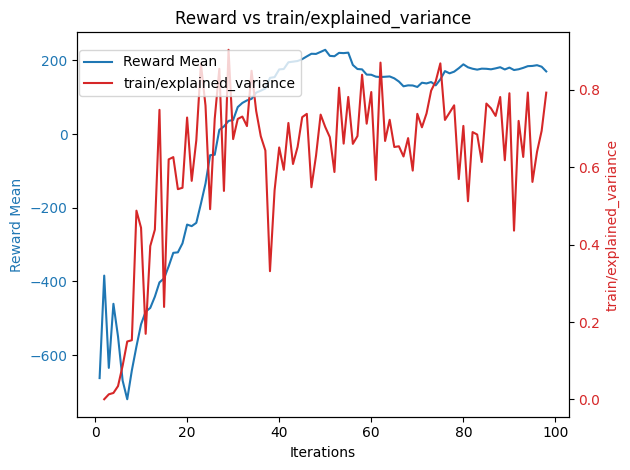

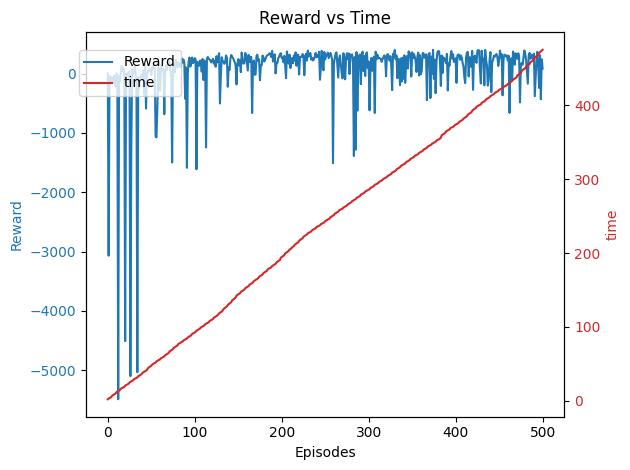

In [5]:
train_data_log: DataFrame = pd.read_csv(logs_path+"progress.csv")
train_data_monitor: DataFrame = pd.read_csv(logs_path+"monitor.csv", header=1)


print("Avaliable metrics: ", train_data_log.columns.to_list())

fig, ax1 = plt.subplots()

iterations: Series[int] = train_data_log['time/iterations'].astype(int)


ax1.set_xlabel('Iterations')
color = 'tab:blue'
ax1.set_ylabel('Reward Mean', color=color)
ax1.plot(iterations,
         train_data_log['rollout/ep_rew_mean'], color=color, label='Reward Mean')
ax1.tick_params(axis='y', labelcolor=color)


col = 'train/explained_variance'

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel(col, color=color)
ax2.plot(iterations, train_data_log[col], color=color, label=col)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_title('Reward vs ' + col)


fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()


fig, ax1 = plt.subplots()

episodes = range(len(train_data_monitor['l']))


ax1.set_xlabel('Episodes')
color = 'tab:blue'
ax1.set_ylabel('Reward', color=color)
ax1.plot(episodes, train_data_monitor['r'], color=color, label='Reward')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Reward vs Time')


ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('time', color=color)
ax2.plot(episodes, train_data_monitor['t'], color=color, label='time')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

## Comprobación funcionamiento


In [6]:
seed = 289980628190634006122751570777790489191
env = make(env_id, seed=seed)
seed: int = env.np_random_seed
model = PPO.load(name, print_system_info=True)

num_steps = 1
obs, _ = env.reset(seed=seed)
# Variables de información:

stats = []
rewards = []

# -------------------------

_states = None
ant = env._get_info()
for episode in range(num_steps):

    done = False
    step_counter = 0
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, terminated, info = env.step(action)

        stats.append(info["Stats"])
        rewards.append(reward)

        done: bool = done or terminated

    env.reset(seed=seed)
    step_counter += 1

# Debug
acciones = [x["Action"] for x in stats]
calcular_stats_acciones(acciones)

print(f"Seed: {env.np_random_seed}")

== CURRENT SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

== SAVED MODEL SYSTEM INFO ==
- OS: Windows-10-10.0.19045-SP0 10.0.19045
- Python: 3.12.6
- Stable-Baselines3: 2.4.1
- PyTorch: 2.5.1+cpu
- GPU Enabled: False
- Numpy: 1.26.4
- Cloudpickle: 3.1.0
- Gymnasium: 1.0.0

DENEGAR: 7.75%
PERMITIR: 92.25%
Seed: 289980628190634006122751570777790489191


In [7]:
assert len(acciones) != acciones.count(
    Acciones.DENEGAR), "Se han denegado todos los paquetes"
assert len(acciones) != acciones.count(
    Acciones.PERMITIR), "Se han permitido todos los paquetes"

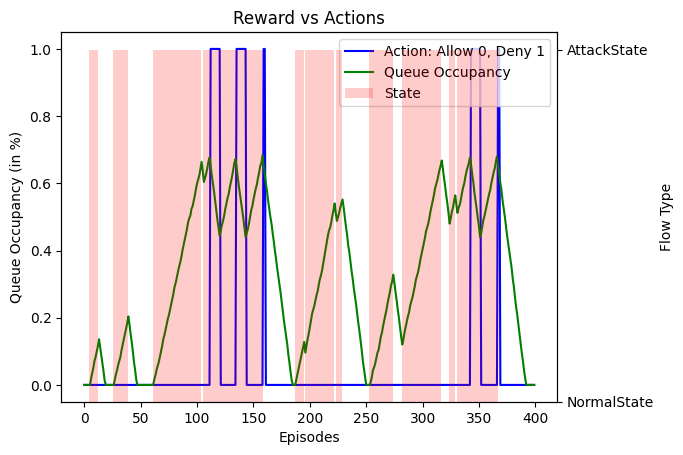

Rewards:  [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.726, -2.722, -2.726, -2.726, -2.472, -2.472, -2.472, -2.726, -2.726, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.726, -2.722, -2.472, -2.476, -2.476, -2.726, -2.476, -2.722, -2.472, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, -2.472, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.

In [8]:
assert len(acciones) == len(rewards)
# plt.plot(rewards, label="rewards")

fig, ax1 = plt.subplots()
ocu = [x["OcupacionActual"] for x in stats]
estados = [x["EstadoMaquina"] for x in stats]
acciones = [Acciones.action_to_int(x["Action"]) for x in stats]

# Primer eje Y con acciones y ocupación de cola
ax1.plot(
    acciones, label=f"Action: Allow {Acciones.action_to_int(Acciones.PERMITIR)}, Deny {Acciones.action_to_int(Acciones.DENEGAR)}", color='#0000FF')
ax1.plot(ocu, label="Queue Occupancy", color='green')
ax1.set_xlabel("Episodes")
ax1.set_ylabel("Queue Occupancy (in %)")
ax1.set_title("Reward vs Actions")

# Segundo eje Y con estados en gráfico de barras
ax2 = ax1.twinx()
ax2.bar(range(len(estados)), estados, color='red',
        label="State", alpha=0.20, width=1)
ax2.set_ylabel("Flow Type")

# Combinar leyendas de ambos ejes
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2)

plt.show()


print("Rewards: ", rewards)
calcular_stats_acciones(acciones)

Ocupación:  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.02, 0.036, 0.052, 0.072, 0.084, 0.1, 0.116, 0.136, 0.112, 0.088, 0.064, 0.04, 0.012, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.032, 0.044, 0.06, 0.072, 0.084, 0.104, 0.12, 0.136, 0.152, 0.168, 0.184, 0.204, 0.18, 0.152, 0.128, 0.1, 0.068, 0.044, 0.016, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016, 0.028, 0.044, 0.056, 0.068, 0.084, 0.1, 0.116, 0.136, 0.148, 0.164, 0.18, 0.196, 0.208, 0.224, 0.24, 0.256, 0.272, 0.292, 0.304, 0.32, 0.336, 0.352, 0.364, 0.38, 0.4, 0.416, 0.432, 0.448, 0.464, 0.484, 0.496, 0.504, 0.524, 0.532, 0.548, 0.564, 0.584, 0.6, 0.612, 0.624, 0.644, 0.664, 0.636, 0.604, 0.616, 0.628, 0.644, 0.664, 0.676, 0.652, 0.624, 0.6, 0.576, 0.548, 0.52, 0.492, 0.468, 0.444, 0.46, 0.476, 0.488, 0.504, 0.524, 0.54, 0.556, 0.568, 0.588, 0.604, 0.62, 0.64, 0.66, 0.672, 0.648, 0.62, 0.592, 0.568, 0.544, 0.52, 0.496, 0.468, 0.44, 0.452, 0.464, 0.48, 0.5, 0.52, 0.532, 0.552, 0.568, 0.584, 0.596, 0

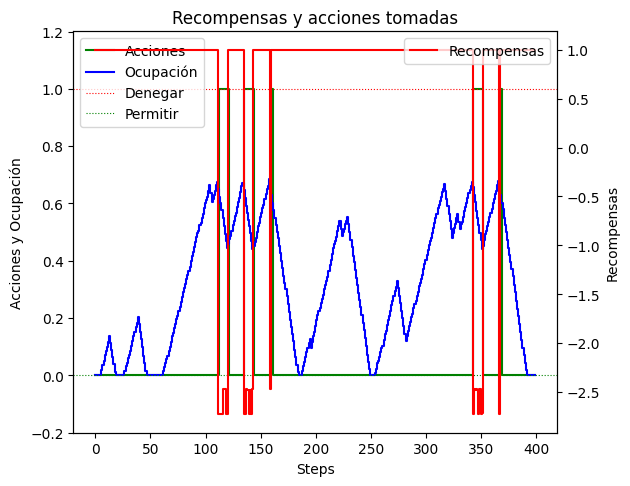

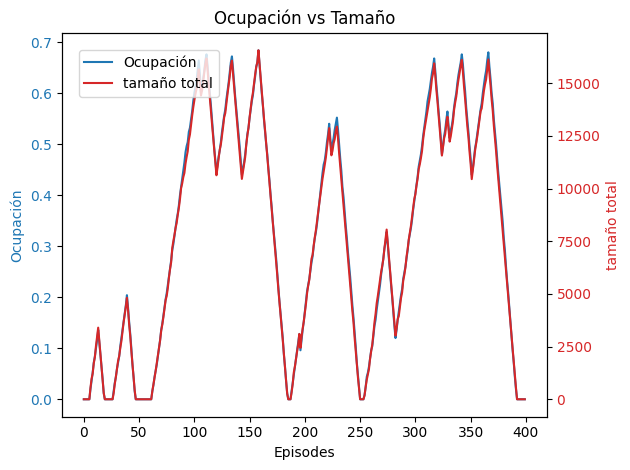

La ocupación máxima es de 68%
La ocupación mínima es de 0%


In [9]:
print("Ocupación: ", ocu)
fig, ax1 = plt.subplots()

# Configurar el eje X e Y
ax1.set_xlabel('Steps')
ax1.set_ylabel('Acciones y Ocupación')

# Graficar las acciones y la ocupación
ax1.step(range(len(acciones)), acciones,
         label="Acciones", where='post', color='green')
ax1.step(range(len(ocu)), ocu, label="Ocupación", where='mid', color='blue')


# Agregar marca en el eje Y
ticks = list(ax1.get_yticks())  # Obtener los ticks actuales

ax1.set_yticks(sorted(ticks))  # Actualizar los ticks


ax1.axhline(y=Acciones.action_to_int(Acciones.DENEGAR), color='red',
            linestyle='dotted', linewidth=0.8, label='Denegar')
ax1.axhline(y=Acciones.action_to_int(Acciones.PERMITIR),
            color='green', linestyle='dotted', linewidth=0.8, label='Permitir')


# Leyenda del primer eje
ax1.legend(loc='upper left')

# Crear segundo eje Y para las recompensas
ax2 = ax1.twinx()
ax2.set_ylabel('Recompensas')
ax2.step(range(len(rewards)), rewards,
         label="Recompensas", where='mid', color='r')

# Leyenda del segundo eje
ax2.legend(loc='upper right')

# Ajustar diseño y mostrar título
fig.tight_layout()
plt.title("Recompensas y acciones tomadas")
plt.show()


tam = [x["TamañoTotal"] for x in stats]


fig, ax1 = plt.subplots()

train_data_monitor: DataFrame = pd.read_csv(logs_path+"monitor.csv", header=1)

episodes = range(len(train_data_monitor['l']))

# Plot rollout/ep_rew_mean on the first y-axis
ax1.set_xlabel('Episodes')
color = 'tab:blue'
label = 'Ocupación'
ax1.set_ylabel(label, color=color)
ax1.plot(range(len(ocu)), ocu, color=color, label=label)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_title('Ocupación vs Tamaño')


ax2 = ax1.twinx()
color = 'tab:red'
label = 'tamaño total'
ax2.set_ylabel(label, color=color)
ax2.plot(range(len(tam)), tam, color=color, label=label)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
fig.legend(loc='upper left', bbox_to_anchor=(0.12, 0.9))

plt.show()

print(f"La ocupación máxima es de {np.max(ocu):.0%}")
print(f"La ocupación mínima es de {np.min(ocu):.0%}")